In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statistics
pd.set_option('display.max_columns',500)

In [59]:
df = pd.read_csv("csv_data/merged/Spring2020Merged_goodRuns.csv")

In [60]:
# won't be right until dataset is updated
# selects runs that have a single nudge of a normal size
df_good = df[(df['RunHasNudge'])&(~df['RunHasAbnormalNudge'])&(df['TotalNudges_thisRun']==1)]

In [61]:
# copy viz code from other notebook (or make it a utility aviailble to all would be better)
single_nudge_run_list = df_good['RunNumber'].unique()

In [126]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import statistics
pd.set_option('display.max_columns',500)

def plot_run(runNumber):

    print("plotting for run ",runNumber)
    # RunHasNudge only true for moment nudge occurs (need to fix still)
    df_run_nudges = df_good[((df_good['RunNumber']==runNumber)&(df_good['NudgeOccurred']))]
    df_run_nudges.reset_index(inplace=True)

    nudge_list = df_run_nudges['NudgeNumber'].unique()

    #if len(nudge_list)<3:
    #    return

    yvals = list(df_run_nudges['CBREM:ENERGY'])   

    fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
    
    set_energy_drawn = False
    nudge_label_set = False
    first_good_nudge = False

    nudge_times = []
    pitchDiffs = []
    yawDiffs = []
    enDiffs = []
    set_ens = []

    first_time = 0
    max_nudge_time = 0
    
    
    for seq in nudge_list:

        df_this_nudge = df_run_nudges[df_run_nudges['NudgeNumber']==seq]
        df_this_nudge.reset_index(inplace=True)
        nudge_time = df_this_nudge.loc[0,'TimeStamp']

        if first_time==0:
            first_time = nudge_time

        current_pitchDiff = df_this_nudge.loc[0,'NudgePitchSize']        
        current_yawDiff = df_this_nudge.loc[0,'NudgeYawSize']
        current_roll = df_this_nudge.loc[0,'GONI:ROLL']

        # no clue what is causing this, nudges should never be this big. Config change?
        if abs(current_pitchDiff)>1 or abs(current_yawDiff)>1:
            #print(df_this_nudge)
            continue

        pitchDiffs.append(current_pitchDiff)
        yawDiffs.append(current_yawDiff)
        nudge_times.append(nudge_time)
            
        if nudge_time>max_nudge_time:
            max_nudge_time = nudge_time

        nudgeSize = (current_pitchDiff**2+current_yawDiff**2)**0.5

        # nudge of 0.001 should give 1 MeV change (is what I have been told)
        if abs(current_roll-34.5)<1.0:
            # all roll 34.5 configs have a negative E_gam change with a postive change in yaw
            if current_yawDiff>0:
                nudgeSize = -nudgeSize
        elif abs(current_roll+10.5)<1:
            # roll -10.5 PARA has +delta(yaw)->-delta(E)
            # but for PERP, yaw is fixed and +delta(pitch)->-delta(E)
            if df_this_nudge.loc[0,'CBREM:PLANE']==2:
                # PERP
                if current_pitchDiff>0:
                    nudgeSize = -nudgeSize
            elif df_this_nudge.loc[0,'CBREM:PLANE']==1:
                if current_yawDiff>0:
                    nudgeSize = -nudgeSize
        expectedEnChange = 3.0*nudgeSize/0.001

        # estimate measured energy value after this nudge
        if not first_good_nudge:
            # take current energy and add estimated effect of this nudge
            current_energy = df_this_nudge.loc[0,'CBREM:ENERGY']
            # getting an accurate start energy is essential for the estimates to be close. Check past 10 seconds in df_good to 
            # ensure this energy not a fluke. 
            this_time = df_this_nudge.loc[0,'TimeStamp']
            # find the last ten energies in a reasonable energy range
            df_time_window = df_good[(df_good['TimeStamp']<=this_time)&(df_good['CBREM:ENERGY']>8550)&(df_good['CBREM:ENERGY']<8650)]
            df_time_window.reset_index()
            
            energies_in_window = list(df_time_window['CBREM:ENERGY'].tail(10))
            mean_energy = np.mean(energies_in_window)

            if abs(current_energy-mean_energy)>10:
                print("energy of",current_energy,"more than 10 MeV from mean from last 10 seconds ",mean_energy)
                median_energy = statistics.median(energies_in_window)
                print("resetting to median value of ",median_energy)
                print(energies_in_window)
                current_energy = median_energy
            
            set_ens.append(current_energy+expectedEnChange)
            first_good_nudge = True
        else:
            # take previous estimated set energy and add new expected change
            set_ens.append(set_ens[-1]+expectedEnChange)

        if not nudge_label_set:
            ax1.axvline(nudge_time,color='r',linestyle='--',label='Nudge')
            nudge_label_set = True
        else:
            ax1.axvline(nudge_time,color='r',linestyle='--')
        
        if not set_energy_drawn:
            set_val = df_this_nudge['CBREM:SET_ENERGY'].unique()[0]
            ax1.axhline(y=set_val,color='g',linestyle='--',label='Set Energy')
            ax1.axhspan(set_val-10,set_val+10,color='g',alpha=0.1)

            #ax3.axhline(y=set_val,color='g',linestyle='--',label='Set Energy')
            #ax3.axhspan(set_val-10,set_val+10,color='g',alpha=0.1)
            set_energy_drawn = True
           
    # get the time when the DAQ turned on (status 2)
    df_daq_on = df_good[(df_good['RunNumber']==runNumber)&(df_good['DAQ:STATUS']==2)]
    df_daq_on.reset_index(inplace=True)
    end_time = df_daq_on.loc[0,'TimeStamp']

    # df to get 30 seconds after daq on or last nudge, which ever is later 
    df_end = df_good[(df_good['RunNumber']==runNumber)&(df_good['TimeStamp']>=max(max_nudge_time,end_time))]
    df_end.reset_index(inplace=True)
    end_times = list(df_end.loc[0:30,'TimeStamp'])

    ax2.plot(nudge_times,yawDiffs,label='YawDiff',marker='o')
    ax2.plot(nudge_times,pitchDiffs,label='PitchDiff',marker='o')
    ax2.set_ylabel('Difference (Degrees)')
    plt.xlabel("Time Stamp (s)")
    ax2.legend()
    

    if len(end_times)>0:
        ax1.axvline(end_times[0],color='black',label='DAQ On')

        if end_times[0]>max_nudge_time:
            nudge_times+=end_times
            set_ens += [set_ens[-1] for i in range(len(end_times))]

    df_vis = df_good[(df_good['TimeStamp']>=first_time-30)&(df_good['TimeStamp']<=max(end_times))&(df_good['CBREM:ENERGY']<8650)&(df_good['CBREM:ENERGY']>8550)]

    ax1.plot(df_vis['TimeStamp'],df_vis['CBREM:ENERGY'],color='b')
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    
    #ax3.plot(nudge_times,set_ens,color='b',linestyle='--',label='Estimated Set')
    #ax3.plot(df_vis['TimeStamp'],df_vis['CBREM:ENERGY'],color='b',label='Measured')
 
    #ax3.legend()
    
    plane_value = df_end.loc[0,'CBREM:PLANE']
    roll_value = df_end.loc[0,'GONI:ROLL']

    plane_str = 'PARA'
    if plane_value==2:
        plane_str = "PERP"
    elif plane_value==0:
        plane_str = "Undefined"
    
    outStr = "0_90"
    orStr = "0/90 "
    if roll_value>30:
        orStr = "45/135 "
        outStr = "45_135"

    titleStr = 'Run Number '+str(runNumber)+" "+orStr+" "+plane_str
    
    ax1.set_title(titleStr)

    ax1.set_ylabel("Photon Energy (GeV)")
    ax1.legend()

    plt.savefig("plots/singleNudge/"+outStr+"_"+plane_str+"/plot_run_"+str(runNumber)+".pdf")
 
    #plt.savefig("plots/singleNudge/plot_run_"+str(runNumber)+".pdf")
    plt.show()

    plt.clf()


In [127]:
print(df_good.columns)

Index(['Unnamed: 0', 'Date-Time', 'RunNumber', 'DAQ:STATUS', 'CBREM:PLANE',
       'GONI:ROLL', 'GONI:ROLL.RBV', 'GONI:X', 'GONI:X.RBV', 'GONI:Y',
       'GONI:Y.RBV', 'GONI:PITCH', 'GONI:PITCH.RBV', 'GONI:YAW',
       'GONI:YAW.RBV', 'AC:X', 'AC:Y', 'EBEAM:CURRENT', 'EBEAM:ENERGY',
       'EBEAM:X', 'EBEAM:Y', 'CBREM:SET_ENERGY', 'CBREM:ENERGY_UNC',
       'CBREM:ENERGY', 'RADIATOR:ID', 'RADIATOR:NAME', 'TimeStamp',
       'NudgeDuringRun', 'RunHasNudge', 'NudgeOccurred',
       'TotalNudgeSize_thisRun', 'NudgeSequence', 'TotalNudges_thisRun',
       'RunHasAbnormalNudge', 'RunHasBacklash', 'NudgeNumber',
       'NudgePitchSize', 'NudgeYawSize', 'MotionDone', 'NudgeEnSize_15s',
       'NudgeEnSize_17s', 'NudgeEnSize_20s'],
      dtype='object')


plotting for run  72116


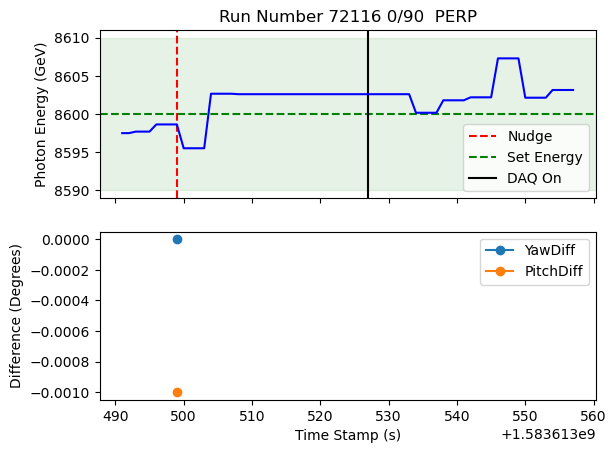

Number of small nudges 1.0
3.96
3.96
3.96
avg en is  3.9599999999999995
plotting for run  72172
energy of 8609.88 more than 10 MeV from mean from last 10 seconds  8622.003
resetting to median value of  8623.35
[8623.35, 8623.35, 8623.35, 8623.35, 8623.35, 8623.35, 8623.35, 8623.35, 8623.35, 8609.88]


<Figure size 640x480 with 0 Axes>

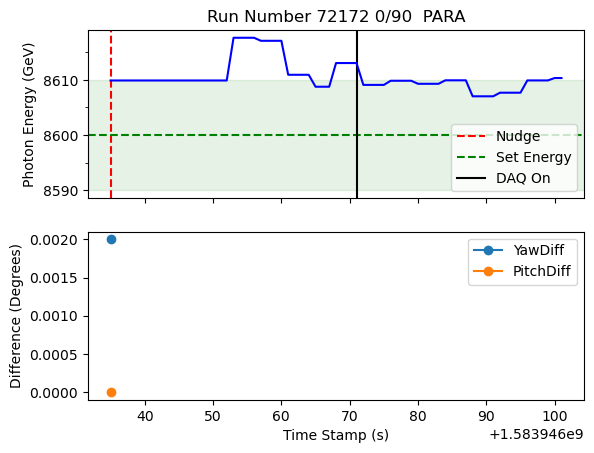

plotting for run  72251


<Figure size 640x480 with 0 Axes>

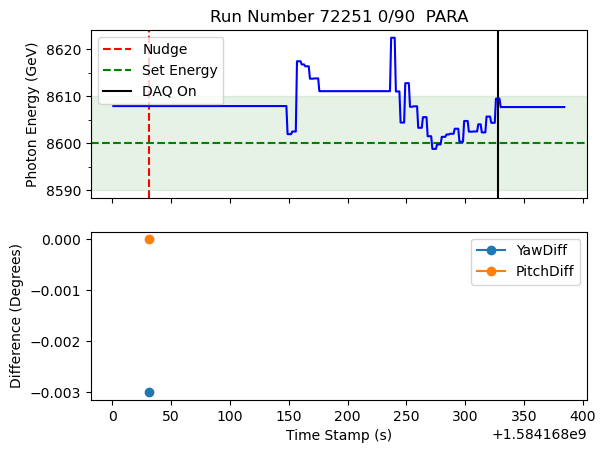

plotting for run  72274


<Figure size 640x480 with 0 Axes>

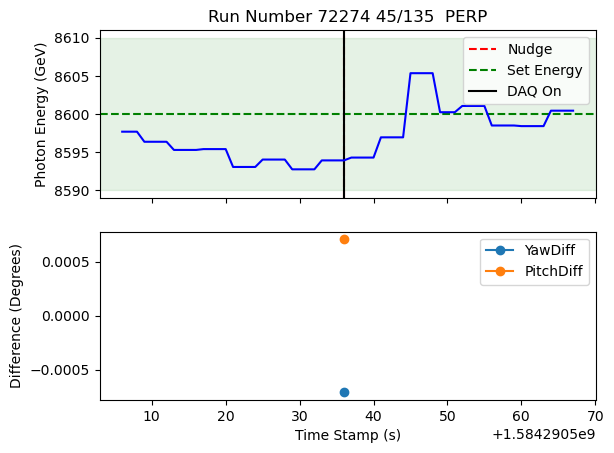

Number of small nudges 1.0
6.31
7.13
4.57
avg en is  6.003333333333333
plotting for run  72293


<Figure size 640x480 with 0 Axes>

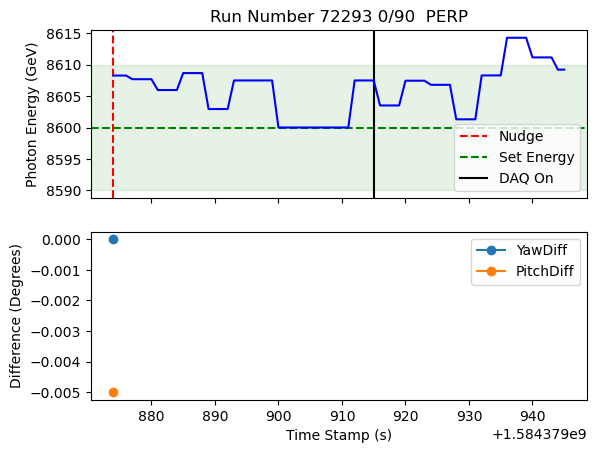

plotting for run  72423


<Figure size 640x480 with 0 Axes>

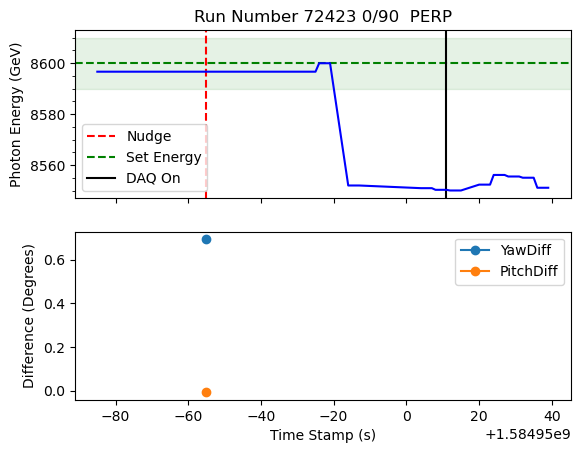

plotting for run  72653


<Figure size 640x480 with 0 Axes>

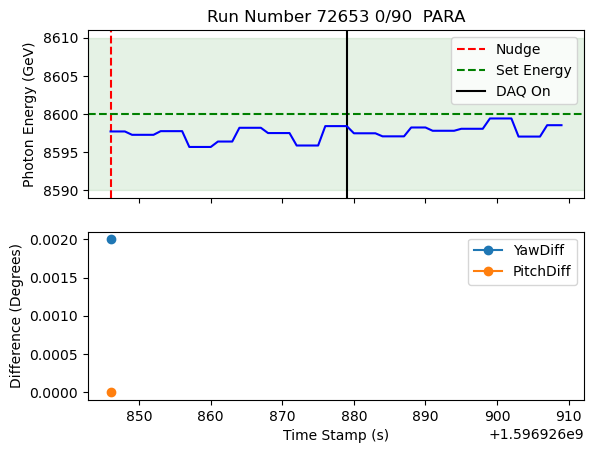

plotting for run  72677


<Figure size 640x480 with 0 Axes>

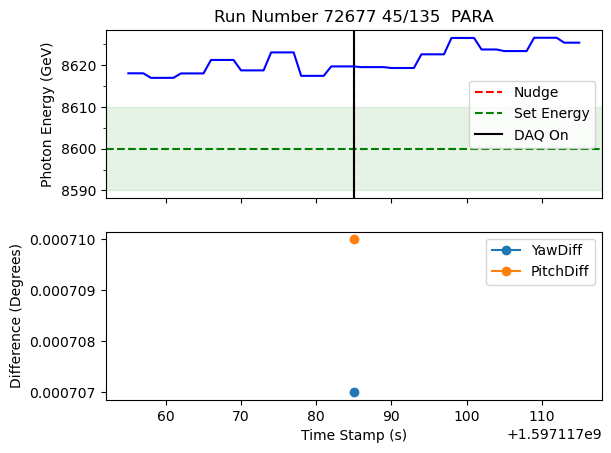

Number of small nudges 1.0
6.82
4.06
3.68
avg en is  4.853333333333333
plotting for run  72768
energy of 8604.04 more than 10 MeV from mean from last 10 seconds  8634.141
resetting to median value of  8637.17
[8638.89, 8638.89, 8636.57, 8636.57, 8636.57, 8636.57, 8637.77, 8637.77, 8637.77, 8604.04]


<Figure size 640x480 with 0 Axes>

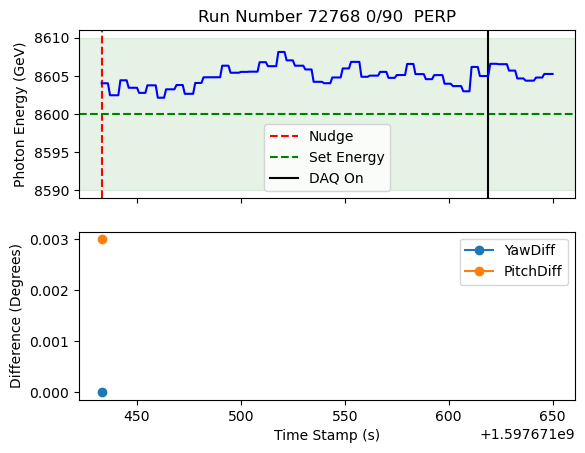

plotting for run  72781


<Figure size 640x480 with 0 Axes>

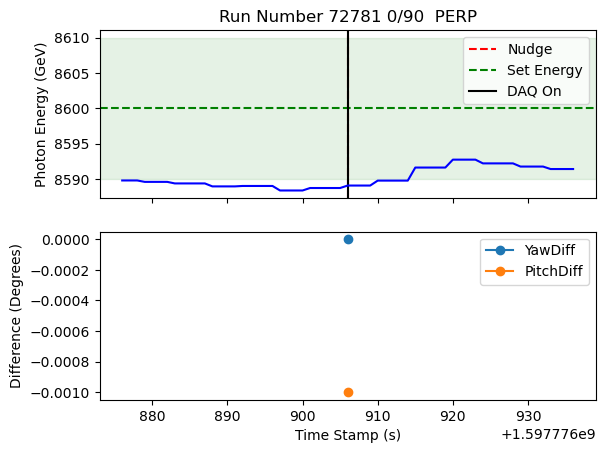

Number of small nudges 1.0
3.67
3.67
3.14
avg en is  3.4933333333333336
plotting for run  72811


<Figure size 640x480 with 0 Axes>

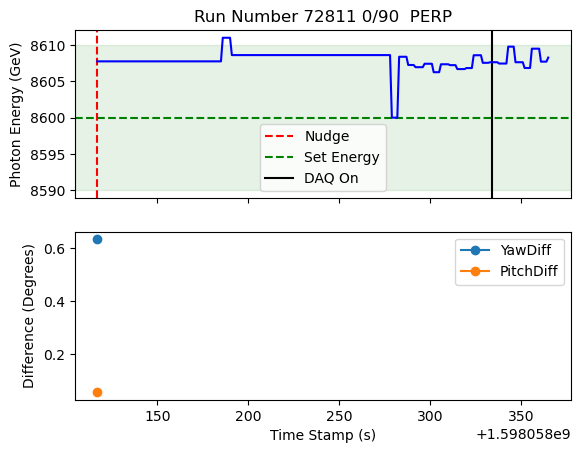

plotting for run  72855


<Figure size 640x480 with 0 Axes>

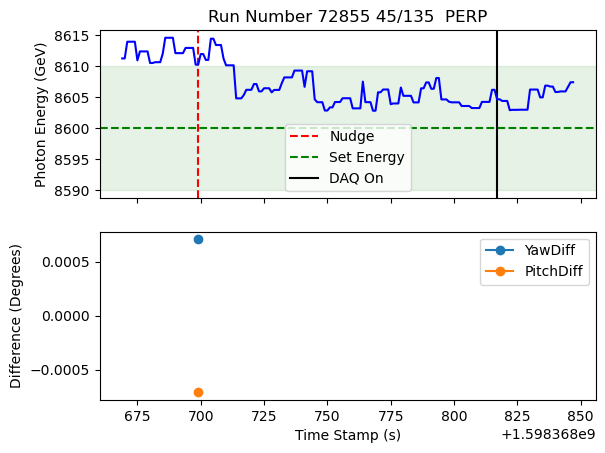

Number of small nudges 1.0
5.44
5.44
4.06
avg en is  4.98
plotting for run  72887


<Figure size 640x480 with 0 Axes>

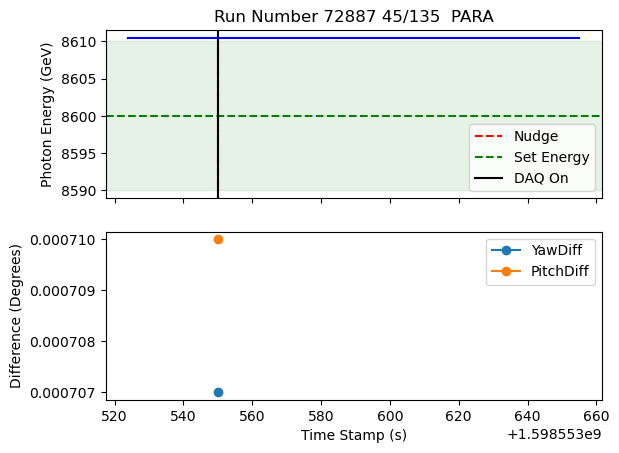

Number of small nudges 1.0
0.0
0.0
0.0
avg en is  0.0
plotting for run  72909


<Figure size 640x480 with 0 Axes>

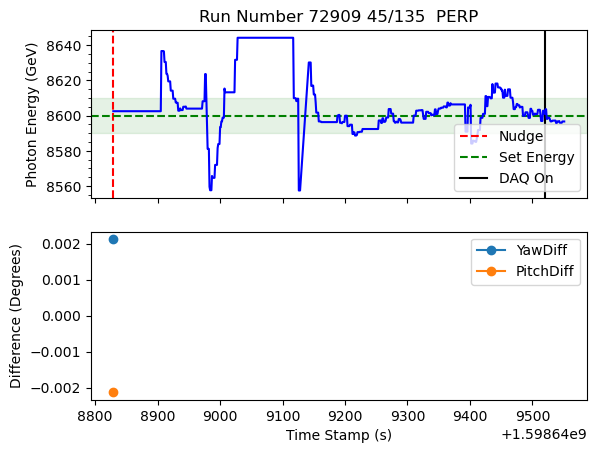

plotting for run  73056


<Figure size 640x480 with 0 Axes>

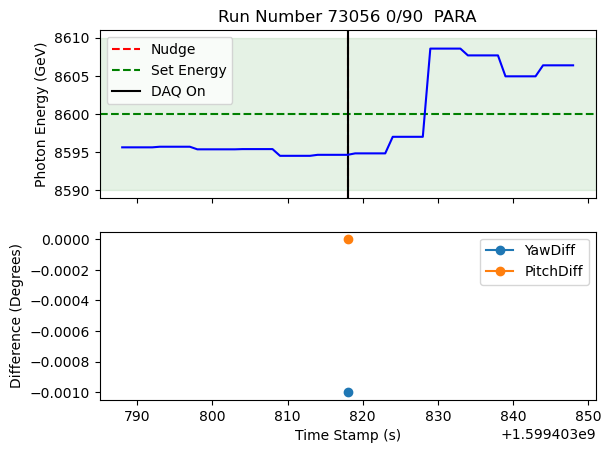

Number of small nudges 1.0
13.91
13.02
13.02
avg en is  13.316666666666668
plotting for run  73112


<Figure size 640x480 with 0 Axes>

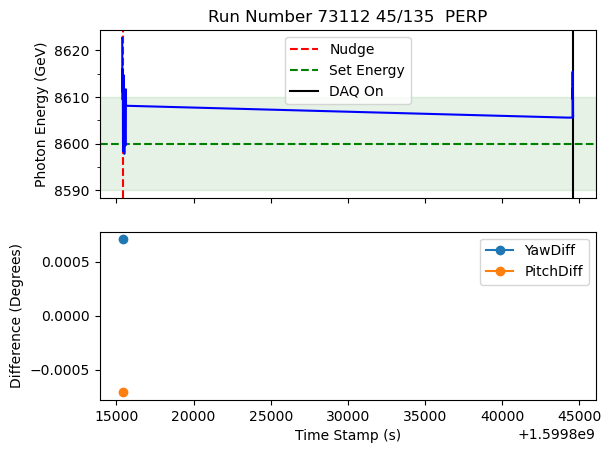

Number of small nudges 1.0
1.02
1.02
8.75
avg en is  3.5966666666666662
plotting for run  73126


<Figure size 640x480 with 0 Axes>

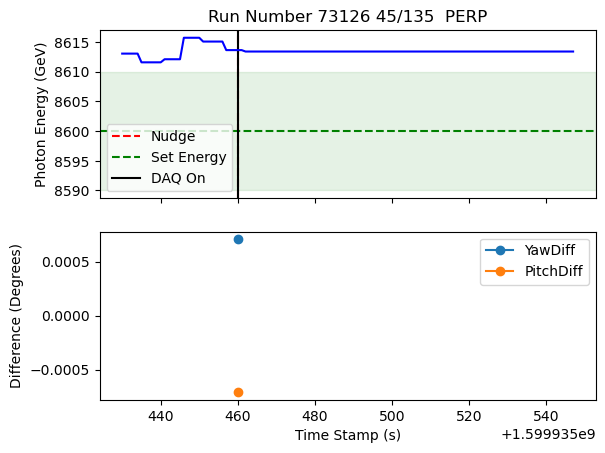

Number of small nudges 1.0
0.24
0.24
0.24
avg en is  0.24
plotting for run  73266
energy of 8596.0 more than 10 MeV from mean from last 10 seconds  8613.316
resetting to median value of  8615.24
[8615.24, 8615.24, 8615.24, 8615.24, 8615.24, 8615.24, 8615.24, 8615.24, 8615.24, 8596.0]


<Figure size 640x480 with 0 Axes>

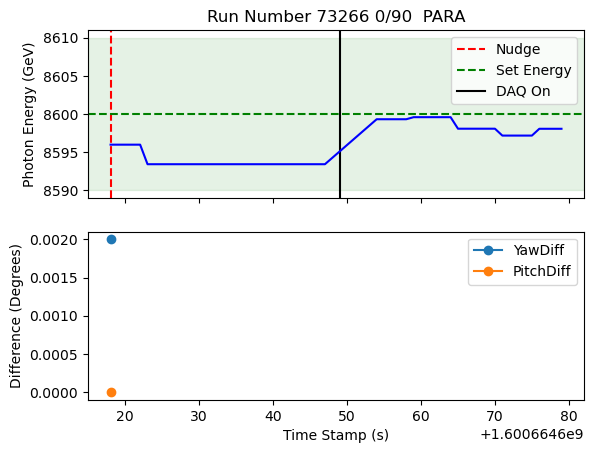

<Figure size 640x480 with 0 Axes>

In [128]:
small_nudge_counts = []
first_energies = []
second_energies = []
third_energies = []

for runNum in single_nudge_run_list:
    plot_run(runNum)
    df_tmp = df_good[(df_good['RunNumber']==runNum)&(df_good['NudgeOccurred'])]
    df_tmp.reset_index(inplace=True)

    num_nudges = round(((df_tmp.loc[0,'NudgeYawSize']**2+df_tmp.loc[0,'NudgePitchSize']**2)**0.5)/0.001,1)
    if num_nudges>1:
        continue
    print("Number of small nudges",num_nudges)
    first_en = round(abs(df_tmp.loc[0,'NudgeEnSize_15s']),4)
    second_en = round(abs(df_tmp.loc[0,'NudgeEnSize_17s']),4)
    third_en = round(abs(df_tmp.loc[0,'NudgeEnSize_20s']),4)

    print(first_en)
    print(second_en)
    print(third_en)


    small_nudge_counts.append(num_nudges)
    print("avg en is ", (first_en+second_en+third_en)/3.0)

    first_energies.append(first_en)
    second_energies.append(second_en)
    third_energies.append(third_en)


13.91


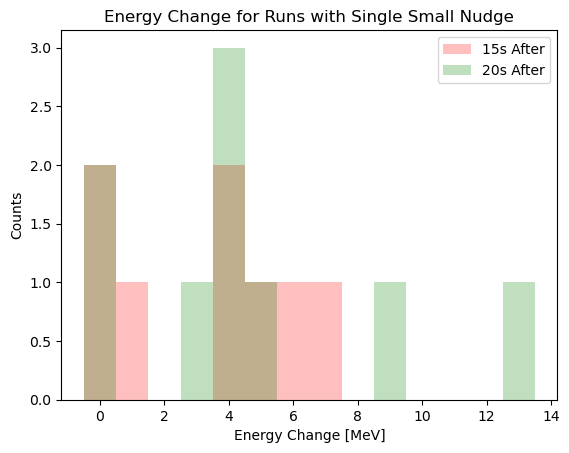

In [130]:
max_val = max(first_energies)
bins = np.arange(-0.5,14.5,1)
plt.hist(first_energies,alpha=0.25,label='15s After',bins=bins,color='r')
#plt.hist(second_energies,alpha=0.25,label='17s After')
plt.hist(third_energies,alpha=0.25,label='20s After',bins=bins,color='g')
plt.xlabel('Energy Change [MeV]')
plt.ylabel("Counts")
plt.title("Energy Change for Runs with Single Small Nudge")
plt.legend()
plt.savefig("plots/singleNudge/energyChangeSummary.pdf")
print(max_val)

In [129]:
print(len(single_nudge_run_list))

18


In [ ]:
from sklearn.linear_model import LinearRegression 

lr = LinearRegression()

print(small_nudge_counts)
print(first_energies)

print(len(small_nudge_counts))
print(len(first_energies))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[3.96, 6.31, 6.82, 3.67, 5.44, 0.0, 13.91, 1.02, 0.24]
9
9


In [100]:
# look at median and average energies
print(np.mean(first_energies))
print(statistics.median(first_energies))

4.596666666666667
3.96


In [101]:
print(np.mean(second_energies))
print(statistics.median(second_energies))

4.282222222222222
3.96


In [102]:
print(np.mean(third_energies))
print(statistics.median(third_energies))

4.602222222222222
3.96
